# Spotify ETL

## Extract

I extracted data from my Spotify account with Spotipy which is a popular wrapper for the Spotify API. It enables and supports all the features of the Spotify API but allows them to be designed and run in Python.

In order to use the API, we have to create a Spotify developer account. In the Spotify app dashboard, we have to register our application and add a redirect url. A redirect url is the location where the authorization server sends the user once the app has been successfully authorized and granted an authorization code or access token.

- *End User* corresponds to the Spotify user. The End User grants access to the protected resources (e.g. playlists, personal information, etc.)

- *My App* is the client that requests access to the protected resources (e.g. a mobile or web app).

- *Server* which hosts the protected resources and provides authentication and authorization via OAuth 2.0.

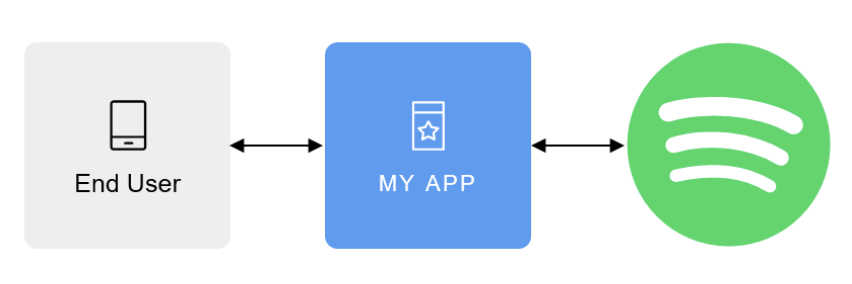

The access to the protected resources is determined by one or several scopes. Scopes enable the application to access specific functionality. In this case, I used user-read-recently-played scope which reads access to a user’s recently played tracks.

The authorization process also requires valid client credentials: a client ID and a client secret. Once the authorization is granted, the authorization server issues an access token, which is used to make API calls on behalf the user or application.With the authenticated spotipy object, we can now request data from the spotify user. I requested my last 50 recently played tracks.

#### Loading Modules

In [4]:
import spotipy #A light weight Python library for the Spotify Web API
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import psycopg2
from cred import spotify_client_id, spotify_client_secret, spotify_redirect_url,password

#### API 

In [37]:
#spotify_client_id = "" 
#spotify_client_secret = ""
#spotify_redirect_url = ""

#authentication
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=spotify_client_id,
                                               client_secret=spotify_client_secret,
                                               redirect_uri=spotify_redirect_url,
                                               scope="user-read-recently-played"))
# Get the current user’s recently played tracks
recently_played = sp.current_user_recently_played(limit=50)

#if no result from api then exit
if len(recently_played) == 0:
    exit()

In [38]:
# returns dictionary
print(recently_played)

{'items': [{'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0du5cEVh5yTK9QJze8zA0C'}, 'href': 'https://api.spotify.com/v1/artists/0du5cEVh5yTK9QJze8zA0C', 'id': '0du5cEVh5yTK9QJze8zA0C', 'name': 'Bruno Mars', 'type': 'artist', 'uri': 'spotify:artist:0du5cEVh5yTK9QJze8zA0C'}], 'available_markets': ['AR', 'AU', 'BN', 'BO', 'BZ', 'CA', 'CL', 'CO', 'CR', 'DO', 'EC', 'GT', 'GY', 'HK', 'HN', 'ID', 'IN', 'KH', 'KR', 'LA', 'MO', 'MX', 'MY', 'NI', 'NZ', 'PA', 'PE', 'PH', 'PY', 'SG', 'SR', 'SV', 'TH', 'TL', 'TW', 'US', 'UY', 'VE', 'VN'], 'external_urls': {'spotify': 'https://open.spotify.com/album/1uyf3l2d4XYwiEqAb7t7fX'}, 'href': 'https://api.spotify.com/v1/albums/1uyf3l2d4XYwiEqAb7t7fX', 'id': '1uyf3l2d4XYwiEqAb7t7fX', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab67616d0000b273f6b55ca93bd33211227b502b', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/ab67616d00001e02f6b55ca93bd33211227b502b', '

In [118]:
for data in recently_played['items']:
    print(item)
    break

{'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0du5cEVh5yTK9QJze8zA0C'}, 'href': 'https://api.spotify.com/v1/artists/0du5cEVh5yTK9QJze8zA0C', 'id': '0du5cEVh5yTK9QJze8zA0C', 'name': 'Bruno Mars', 'type': 'artist', 'uri': 'spotify:artist:0du5cEVh5yTK9QJze8zA0C'}], 'available_markets': ['AR', 'AU', 'BN', 'BO', 'BZ', 'CA', 'CL', 'CO', 'CR', 'DO', 'EC', 'GT', 'GY', 'HK', 'HN', 'ID', 'IN', 'KH', 'KR', 'LA', 'MO', 'MX', 'MY', 'NI', 'NZ', 'PA', 'PE', 'PH', 'PY', 'SG', 'SR', 'SV', 'TH', 'TL', 'TW', 'US', 'UY', 'VE', 'VN'], 'external_urls': {'spotify': 'https://open.spotify.com/album/1uyf3l2d4XYwiEqAb7t7fX'}, 'href': 'https://api.spotify.com/v1/albums/1uyf3l2d4XYwiEqAb7t7fX', 'id': '1uyf3l2d4XYwiEqAb7t7fX', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab67616d0000b273f6b55ca93bd33211227b502b', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/ab67616d00001e02f6b55ca93bd33211227b502b', 'width': 300

## Transform

The API call returns dictionary which I transformed into three DataFrames: 
- Songs
- Albums
- Artists

I created a list for each entity and appended a dictionary for each data point with the respective information to the list. Then, I converted the list of dictionaries as DataFrame. I removed duplicate entries based on the the respective id from the DataFrame. Lastly, I exported each DataFrame as .csv files.

#### Song

In [160]:
song_list = []
for data in recently_played['items']:
    song_id = data['track']['id']
    song_name = data['track']['name']
    song_duration = data['track']['duration_ms']
    song_url = data['track']['external_urls']['spotify']
    song_popularity = data['track']['popularity']
    album_id = data['track']['album']['id']
    artist_id = data['track']['album']['artists'][0]['id']
    song = {'song_id':song_id,'song_name':song_name,'duration_ms':song_duration,'song_url':song_url,
                        'song_popularity':song_popularity,'album_id':album_id,
                        'artist_id':artist_id
                       }
    song_list.append(song)

song_df = pd.DataFrame.from_dict(song_list)
song_df.drop_duplicates(subset=['song_id'],inplace=True)

In [161]:
song_df.head(5)

,song_id,song_name,duration_ms,song_url,song_popularity,album_id,artist_id
0,2tJulUYLDKOg9XrtVkMgcJ,Grenade,222091,https://open.spotify.com/track/2tJulUYLDKOg9Xr...,79,1uyf3l2d4XYwiEqAb7t7fX,0du5cEVh5yTK9QJze8zA0C
1,3goSVuTt3fDYDP6kRnFwuL,Take A Bow,229413,https://open.spotify.com/track/3goSVuTt3fDYDP6...,77,3JSWZWeTHF4HDGt5Eozdy7,5pKCCKE2ajJHZ9KAiaK11H
2,0ByMNEPAPpOR5H69DVrTNy,Don't Stop The Music,267080,https://open.spotify.com/track/0ByMNEPAPpOR5H6...,80,3JSWZWeTHF4HDGt5Eozdy7,5pKCCKE2ajJHZ9KAiaK11H
3,49FYlytm3dAAraYgpoJZux,Umbrella,275986,https://open.spotify.com/track/49FYlytm3dAAraY...,83,3JSWZWeTHF4HDGt5Eozdy7,5pKCCKE2ajJHZ9KAiaK11H
4,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next",207320,https://open.spotify.com/track/3e9HZxeyfWwjeyP...,84,2fYhqwDWXjbpjaIJPEfKFw,66CXWjxzNUsdJxJ2JdwvnR


#### Artist

In [164]:
artist_list = []
for data in recently_played['items']:
    for artist in data["track"]["artists"]:
        artist_id = artist['id']
        artist_name=  artist['name']
        artist_url = artist['external_urls']['spotify']
        artist = {'artist_id':artist_id,'artist_name':artist_name,'artist_url':artist_url}
        artist_list.append(artist)
        
artist_df= pd.DataFrame.from_dict(artist_list)
artist_df.drop_duplicates(subset=['artist_id'],inplace=True)

In [165]:
artist_df.head(5)

,artist_id,artist_name,artist_url
0,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,https://open.spotify.com/artist/0du5cEVh5yTK9Q...
1,5pKCCKE2ajJHZ9KAiaK11H,Rihanna,https://open.spotify.com/artist/5pKCCKE2ajJHZ9...
4,3nFkdlSjzX9mRTtwJOzDYB,JAY-Z,https://open.spotify.com/artist/3nFkdlSjzX9mRT...
5,66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,https://open.spotify.com/artist/66CXWjxzNUsdJx...
9,06HL4z0CvFAxyc27GXpf02,Taylor Swift,https://open.spotify.com/artist/06HL4z0CvFAxyc...


#### Album

In [168]:
album_list = []
for data in recently_played['items']:
    album_id = data['track']['album']['id']
    album_name = data['track']['album']['name']
    release_date = data['track']['album']['release_date']
    total_tracks = data['track']['album']['total_tracks']
    album_url = data['track']['album']['external_urls']['spotify']
    album = {'album_id': album_id,'name': album_name,'release_date':release_date,'total_tracks':total_tracks,'album_url':album_url}
    album_list.append(album)
    
album_df = pd.DataFrame.from_dict(album_list)
album_df.drop_duplicates(subset=['album_id'],inplace=True)

In [169]:
album_df.head(5)

,album_id,name,release_date,total_tracks,album_url
0,1uyf3l2d4XYwiEqAb7t7fX,Doo-Wops & Hooligans,2010-10-05,10,https://open.spotify.com/album/1uyf3l2d4XYwiEq...
1,3JSWZWeTHF4HDGt5Eozdy7,Good Girl Gone Bad: Reloaded,2008-06-02,15,https://open.spotify.com/album/3JSWZWeTHF4HDGt...
4,2fYhqwDWXjbpjaIJPEfKFw,"thank u, next",2019-02-08,12,https://open.spotify.com/album/2fYhqwDWXjbpjaI...
6,3euz4vS7ezKGnNSwgyvKcd,Positions,2020-10-30,14,https://open.spotify.com/album/3euz4vS7ezKGnNS...
8,2QJmrSgbdM35R67eoGQo4j,1989,2014-10-27,13,https://open.spotify.com/album/2QJmrSgbdM35R67...


#### Export DataFrames

In [170]:
song_df.to_csv('songs.csv',index=False)
album_df.to_csv('albums.csv',index=False)
artist_df.to_csv('artists.csv',index=False)

## Load

I loaded all the data into the default Postgres Database. I created three tables: *Songs, Albums, Artists*.
The primary keys are song_id, album_id, artist_id, respectively. The album_id and artist_id in the *Songs* table references album_id of *Albums* table and artists_id of *Artists* table. The ER digram below shows that
an album can have mutiples songs and an artist can multiple songs. Addtionaly, each album must have at least one song and each artist must have at least one song.

![ERD%20with%20colored%20entities%20%28UML%20notation%29%20(3).png](attachment:ERD%20with%20colored%20entities%20%28UML%20notation%29%20(3).png)
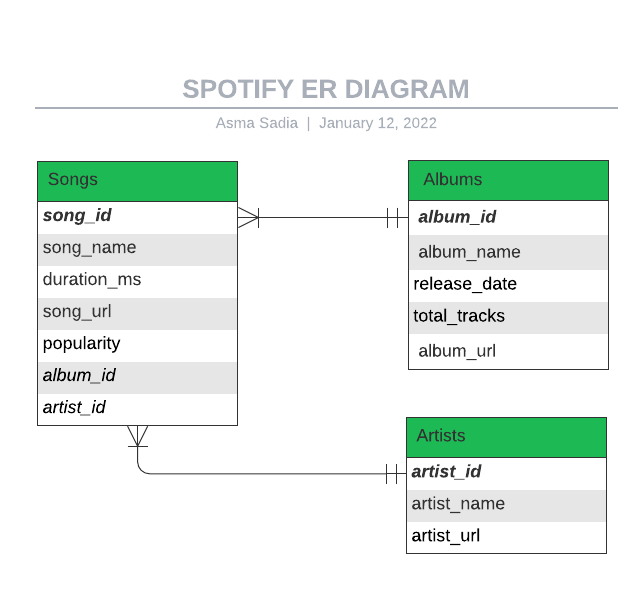

#### Load Artists Table

In [183]:
conn = psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password="sadia123")
conn.autocommit = True

In [184]:
cur = conn.cursor()
artist_table = """ Create table Artists(
                        artist_id        text primary key,
                        artist_name      text,
                        artist_url       text
                ) """

cur.execute(artist_table)
conn.commit()

In [185]:
with open('artists.csv', 'r') as f:
    next(f) 
    cur.copy_from(f, 'artists', sep=',')
conn.commit()
conn.close()

#### Load Albums Table

In [186]:
conn = psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password="sadia123")
conn.autocommit = True

In [187]:
cur = conn.cursor()
album_table = """Create table Albums(
                    album_id           text  primary key,
                    album_name         text,
                    release_date       date,
                    total_tracks       integer,
                    album_url          text
                )"""
cur.execute(album_table)
conn.commit()

In [188]:
with open('albums.csv', 'r') as f:
    next(f) # Skip the header row.
    cur.copy_from(f, 'albums', sep=',')
conn.commit()
conn.close()

#### Load Songs Table

In [189]:
conn = psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password="sadia123")
conn.autocommit = True

In [190]:
cur = conn.cursor()
song_table = """Create table Songs(
                    song_id     text  primary key,
                    song_name   text,
                    duration_ms bigint,
                    song_url    text,
                    popularity  int,
                    album_id    text references Albums(album_id),
                    artist_id   text references Artists(artist_id)
                )"""
cur.execute(song_table)
conn.commit()

In [191]:
with open('songs.csv', 'r') as f:
    next(f) # Skip the header row.
    cur.copy_from(f, 'songs', sep=',')
conn.commit()
conn.close()

## Queries

#### The most streamed artists

In [196]:
with psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password="sadia123") as conn:

    #select artist_name, number of times streamed 
    #join songs and artist on artist_id
    #group streamed by artist_name
    #order streamed in desc
    query1 = """select artist_name,count(*) streamed 
                from songs 
                    inner join artists 
                        on songs.artist_id = artists.artist_id 
                group by artist_name
                order by 2 desc """
    
    most_streamed_artists = pd.read_sql_query(query1,conn)

most_streamed_artists.head(5)

,artist_name,streamed
0,Olivia Rodrigo,4
1,Ariana Grande,4
2,Taylor Swift,4
3,Rihanna,3
4,Demi Lovato,3


#### The most streamed albums

In [211]:
with psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password="sadia123") as conn:
    
    #select album_name, artist_name, number of times streamed 
    #join songs and artist on artist_id
    #join songs and album on album_id
    #group streamed by artist_name & album_name
    #order streamed in desc, artist_name
    
    query2 = """select album_name,artist_name,count(song_name) streamed
                from songs 
                    inner join artists 
                        on songs.artist_id = artists.artist_id
                    inner join albums 
                        on albums.album_id = songs.album_id
                group by artist_name,album_name
                order by 3 desc, artist_name"""
    
    most_streamed_albums = pd.read_sql_query(query2,conn)
    
most_streamed_albums.head(10)

,album_name,artist_name,streamed
0,SOUR,Olivia Rodrigo,4
1,Confident,Demi Lovato,3
2,Teenage Dream,Katy Perry,3
3,Good Girl Gone Bad: Reloaded,Rihanna,3
4,21,Adele,2
5,Positions,Ariana Grande,2
6,thank u next,Ariana Grande,2
7,When The Sun Goes Down,Selena Gomez & The Scene,2
8,1989,Taylor Swift,2
9,25,Adele,1


#### The longest streamed songs

In [213]:
with psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password="sadia123") as conn:
    #select artist_name, song_name, duration_ms
    #join songs and artist on artist_id
    #order duration_ms in desc
    query3 = """select artist_name,song_name, duration_ms 
                from songs 
                    inner join artists 
                        on songs.artist_id = artists.artist_id 
                order by 3 desc"""
    
    longest_streamed_song = pd.read_sql_query(query3,conn)
    
longest_streamed_song.head()

,artist_name,song_name,duration_ms
0,Rihanna,Umbrella,275986
1,Rihanna,Don't Stop The Music,267080
2,Adele,Set Fire to the Rain,242973
3,Olivia Rodrigo,drivers license,242013
4,Sam Smith,I'm Not The Only One,239316


#### The Count of Songs and Albums released each year 

In [214]:
with psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password="sadia123") as conn:
    
    #select year from release_date as release_year, song_count, distinct album_count
    #join albums and songs on album_id
    #group both counts by release_year
    #order release_year in desc
    query4 = """ select Date_part('year',release_date) as release_year,
                 count(song_name) song_count, count(distinct(album_name)) album_count 
                 from albums inner join songs 
                        on albums.album_id = songs.album_id 
                group by release_year 
                order by 1 desc;
            """
    song_album_count = pd.read_sql_query(query4,conn)
    
song_album_count.head()

,release_year,song_count,album_count
0,2021.0,5,2
1,2020.0,3,2
2,2019.0,3,2
3,2015.0,4,2
4,2014.0,3,2


#### The top five most popular songs

In [219]:
with psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password="sadia123") as conn:
    #select artist_name,song_name, max populairty
    #join songs with artists on artist_id
    #join songs with albums on album_id
    #group popularity by artist_name,song_name
    #order popularity in desc
    #five entries
    
    query5 = """ select artist_name, song_name,max(popularity) popularity_index 
                 from songs 
                    inner join artists 
                         on songs.artist_id = artists.artist_id
                    inner join albums 
                         on albums.album_id = songs.album_id
                group by artist_name,song_name
                order by 3 desc limit 5
            """
    top_five_songs = pd.read_sql_query(query5,conn)
    
top_five_songs.head()

,artist_name,song_name,popularity_index
0,Olivia Rodrigo,good 4 u,95
1,Olivia Rodrigo,traitor,93
2,Olivia Rodrigo,drivers license,92
3,Olivia Rodrigo,deja vu,90
4,The Weeknd,Save Your Tears,90


#### The highest popular rank for the common artists

In [215]:
with psycopg2.connect(host='localhost', dbname='postgres', user='postgres', password="sadia123") as conn:
    
    #select artist_name, max populairty
    #join songs with artists on artist_id
    #join songs with albums on album_id
    #group popularity by artist_name
    #that appear more than once
    #order popularity in desc
    
    
    query6 = """Select artist_name, max(popularity) popularity
                from songs inner join artists on 
                    songs.artist_id = artists.artist_id
                inner join albums 
                    on albums.album_id = songs.album_id
                group by artist_name
                having count(artist_name)>1
                order by 2 desc
            """
    artist_highest_pop_index = pd.read_sql_query(query6,conn)

artist_highest_pop_index.head()

,artist_name,popularity
0,Olivia Rodrigo,95
1,Ariana Grande,88
2,Adele,83
3,Selena Gomez & The Scene,83
4,Rihanna,83
